In [1]:
from IPython.display import display, clear_output
from ipywidgets import Button, HBox, Label

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ultralytics import YOLO
import torch
import comet_ml
from comet_ml import Experiment
from comet_ml import Optimizer

import cv2
import PIL.Image as Image

import os
import shutil
import pathlib
import sys
import yaml

In [2]:
# go to parent directory
os.chdir("../..")
import paths

REPO_DIR = paths.get_repo_path()
ROOT_DIR = REPO_DIR / "Stanford Dogs/detection"
DATA_BASE_PATH = paths.get_data_path() / "stanford-dogs-dataset"
dataset_yaml = ROOT_DIR / "dataset.yaml"
SLIDES_PATH = ROOT_DIR / "slides"

# set path to repo_dir
os.chdir(REPO_DIR)

## Dataset


### Dataset & Model Constants

In [3]:
PROJECT_NAME = "dog_breed_detection"

RANDOM_SEED = 42
IMAGE_SIZE = 640

BATCH_SIZE = 2          # Platform Dependent; 
                            # 32-64 for rtX 5000 series
                            # 1-4 for mac m1
DEVICE = "mps"         # Platform Dependent. mps, cuda(0, 1, ...), cpu

yaml_file_path = ROOT_DIR / "dataset.yaml"
with open(yaml_file_path, "r") as f:
    dataset_details = yaml.safe_load(f)

NUM_CLASSES = len(dataset_details["names"])
CLASS_NAMES = dataset_details["names"]

In [4]:
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### Dataset Explore

In [5]:
dataset_df = pd.read_csv(DATA_BASE_PATH / "dogs_df.csv")
dataset_df.head()

,breed,image_path,annotation_path,new_annotation_path
0,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
1,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
2,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
3,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...
4,Affenpinscher,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...,/Users/vineetmahajan/Code/AI/datasets/stanford...


In [35]:
def load_image(image_path):
    image = Image.open(image_path)
    return np.array(image)

def render_results(
    image, 
    boxes: list[float], 
    classes: list[int],
    give_labels: bool = True,
    output_image_longer_side = 640
):
    # image - single image
    # boxes - list of boxes; box = [x, y, w, h]
    # labels - list of labels; label = int
    
    h, w, _ = image.shape
    scale = output_image_longer_side / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    image = cv2.resize(image, (new_w, new_h))
    
    
    cmap = plt.get_cmap("tab20b")
    colors = np.array([cmap(i%20)[:-1] for i in range(NUM_CLASSES)]) * 255

    
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_h, image_w, _ = image_cv.shape
    
    for box, cls in zip(boxes, classes):
        x, y, w, h = box
        x, y, w, h = (
            x * image_w,
            y * image_h,
            w * image_w,
            h * image_h
        )
        
        x1, x2 = int(x - w / 2), int(x + w / 2)
        y1, y2 = int(y - h / 2), int(y + h / 2)
        
        b_col = colors[int(cls)]
        image_cv = cv2.rectangle(image_cv, (x1, y1), (x2, y2), b_col, 3)
        cls_name = CLASS_NAMES[int(cls)]
        
        # add text
        if give_labels:
            text_size, _ = cv2.getTextSize(cls_name, cv2.FONT_HERSHEY_SIMPLEX, 1, 3)
            text_position = (x1 + 1, y2 - 3)
            
            image_cv = cv2.rectangle(
                image_cv,
                (x1, y2),
                (x1 + text_size[0], y2 - text_size[1] - 4),
                b_col,
                -1,  # filled rectangle
            )
            image_cv = cv2.putText(
                image_cv, 
                cls_name, 
                text_position, 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1, 
                (255, 255, 255), 
                2,
                cv2.LINE_AA,
                False,
            )
        
    image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)
        
    return image


In [7]:
slide_vars = {}

def image_slider(images, slide_name=None, num_images=10):
    slide_name = slide_name or np.random.randint(0, 100000)
    if num_images > len(images) or num_images == -1:
        num_images = len(images)

    def save_as_slides(slide_name, images):
        save_path = SLIDES_PATH / f"slide_{slide_name}"

        os.makedirs(save_path, exist_ok=True)
        try:
            shutil.rmtree(save_path)
            os.makedirs(save_path)
            for i, image in enumerate(images):
                image = Image.fromarray(image)
                image.save(save_path / f"{i}.jpg")
        except Exception as e:
            print(e)
            print("Error while saving images as slides")

    def load_slides(slide_num) -> list:
        slide_path = ROOT_DIR / f"slides/slide_{slide_num}"
        images = [str(slide_path / image) for image in os.listdir(slide_path) if image.endswith(".jpg")]
        return str(slide_path), images

    save_as_slides(slide_name, images[:num_images])
    _, images = load_slides(slide_name)

    global slide_vars
    slide_vars[slide_name] = {"image_index": 0}
    current_slide = slide_vars[slide_name]

    # Show image
    def show_image():
        clear_output(wait=True)
        display(HBox([current_slide["previous_button"], current_slide["index_label"],current_slide["next_button"],],layout={'justify_content': 'center'}))
        image_path = images[current_slide["image_index"]]
        image = plt.imread(image_path)
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    def update_label():
        current_slide["index_label"].value = f"{current_slide['image_index'] + 1}/{num_images}"

    def button_click(step):
        current_slide = slide_vars[slide_name]

        idx = current_slide["image_index"] + step
        idx = idx % num_images
        current_slide["image_index"] = idx
        update_label()
        show_image()

    previous_button = Button(description='Previous', button_style='info', layout={'width': 'auto'})
    previous_button.on_click(lambda x: button_click(-1))
    current_slide["previous_button"] = previous_button

    next_button = Button(description='Next', button_style='info', layout={'width': 'auto'})
    next_button.on_click(lambda x: button_click(1))
    current_slide["next_button"] = next_button

    index_label = Label(value=f"{current_slide['image_index'] + 1}/{num_images}")
    current_slide["index_label"] = index_label
    
    show_image()
    


In [8]:
data_sample = dataset_df.sample(8)

images, all_boxes, all_classes = [], [], []

for image_path, annotation_path in zip(data_sample["image_path"], data_sample["new_annotation_path"]):
    image = load_image(image_path)
    images.append(image)

    boxes, classes = [], []
    with open(annotation_path, "r") as f:
        data = f.readlines()
        
    for line in data:
        cls_, x, y, w, h = line.split()
        cls_, x, y, w, h = int(cls_), float(x), float(y), float(w), float(h)
        boxes.append([x, y, w, h])
        classes.append(cls_)
            
    all_boxes.append(boxes)
    all_classes.append(classes)

all_classes

[[94], [18], [116], [7], [114], [34], [117], [110]]

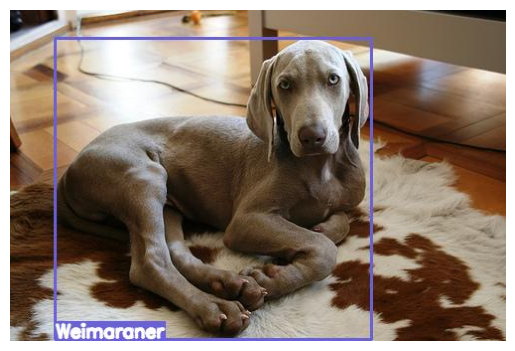

In [9]:
slide_name = 1

result_images = []

for idx in range(len(images)):
    image = images[idx]
    boxes = all_boxes[idx]
    classes = all_classes[idx]

    result_images.append(render_results(image, boxes, classes))

image_slider(result_images, slide_name=slide_name)

result_images = None

## Model

#### Basic inferance

In [12]:
model_name = "yolov8m"
version = "v1"
experiment_name = f"{model_name}-{version}"
# save_dir = f"runs/train/{projext_name}"
resume = False
train = False

if resume:
    pass
    
elif train:
    model = YOLO(model_name)

    model.train(
        data=dataset_yaml, 
        epochs=10, 
        imgsz=IMAGE_SIZE, 
        batch=BATCH_SIZE,
        device=DEVICE,
        project=PROJECT_NAME,
        
        name=experiment_name,
        
        exist_ok=True,
        patience = 10,
        )
else:
    model_path = "runs/detect/yolov8-v1/weights/best.pt"
    model = YOLO(model_path)
    
model.info()

Model summary: 295 layers, 25925800 parameters, 0 gradients, 79.4 GFLOPs


(295, 25925800, 0, 79.4494464)

In [13]:
data_sample = dataset_df.sample(20)

images, all_boxes, all_classes = [], [], []
all_boxes_pred, all_classes_pred = [], []

for image_path, annotation_path in zip(data_sample["image_path"], data_sample["new_annotation_path"]):
    image = load_image(image_path)
    images.append(image)

    boxes, classes = [], []
    
    result = model.predict(image_path)[0].boxes
    boxes_pred = result.xywhn.tolist()
    classes_pred = result.cls.to(torch.int).tolist()
        
    with open(annotation_path, "r") as f:
        data = f.readlines()
        
    for i, line in enumerate(data):
        cls_, x, y, w, h = line.split()
        cls_, x, y, w, h = int(cls_), float(x), float(y), float(w), float(h)
        boxes.append([x, y, w, h])
        classes.append(cls_)
        
        
    all_boxes.append(boxes)
    all_classes.append(classes)
    all_boxes_pred.append(boxes_pred)
    all_classes_pred.append(classes_pred)

all_classes, all_classes_pred


image 1/1 /Users/vineetmahajan/Code/AI/datasets/stanford-dogs-dataset/images/Images/n02088094-Afghan_hound/n02088094_1167.jpg: 448x640 1 Afghan Hound, 207.0ms
Speed: 2.4ms preprocess, 207.0ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/vineetmahajan/Code/AI/datasets/stanford-dogs-dataset/images/Images/n02090622-borzoi/n02090622_6588.jpg: 480x640 1 Borzoi, 213.3ms
Speed: 1.1ms preprocess, 213.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/vineetmahajan/Code/AI/datasets/stanford-dogs-dataset/images/Images/n02109525-Saint_Bernard/n02109525_13794.jpg: 480x640 1 Saint Bernard, 203.6ms
Speed: 1.1ms preprocess, 203.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/vineetmahajan/Code/AI/datasets/stanford-dogs-dataset/images/Images/n02102973-Irish_water_spaniel/n02102973_3195.jpg: 544x640 1 Irish Water Spaniel, 225.0ms
Speed: 1.3ms preprocess, 225.0ms inference, 0.5ms postprocess

([[1],
  [18],
  [92],
  [58],
  [90],
  [113],
  [119],
  [7],
  [94],
  [86],
  [69],
  [11],
  [45],
  [97],
  [72],
  [103],
  [54],
  [45],
  [42],
  [115]],
 [[1],
  [18],
  [92],
  [58],
  [90, 90],
  [113],
  [119],
  [7],
  [94],
  [86],
  [69],
  [11],
  [45],
  [97],
  [72],
  [103],
  [54],
  [45],
  [42],
  [115]])

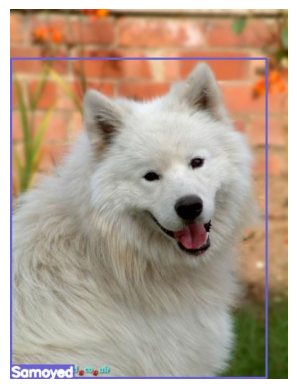

In [14]:
slide_name = "2-original"

result_images = []

for idx in range(len(images)):
    image = images[idx]
    boxes = all_boxes[idx]
    classes = all_classes[idx]

    result_images.append(render_results(image, boxes, classes))

image_slider(result_images, slide_name=slide_name, num_images=-1)

result_images = None


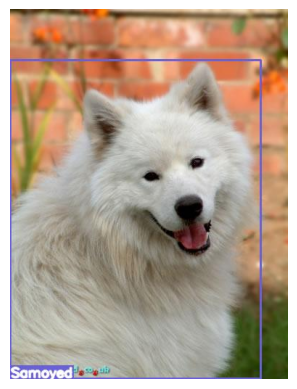

In [15]:
slide_name = "2-pred"

result_images = []

for idx in range(len(images)):
    image = images[idx]
    boxes = all_boxes_pred[idx]
    classes = all_classes_pred[idx]

    result_images.append(render_results(image, boxes, classes))

image_slider(result_images, slide_name=slide_name, num_images=-1)

result_images = None


image 1/1 /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/real-life-images/gsd-rottie.jpg: 352x640 1 German Shepherd, 1 Rottweiler, 199.5ms
Speed: 1.4ms preprocess, 199.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


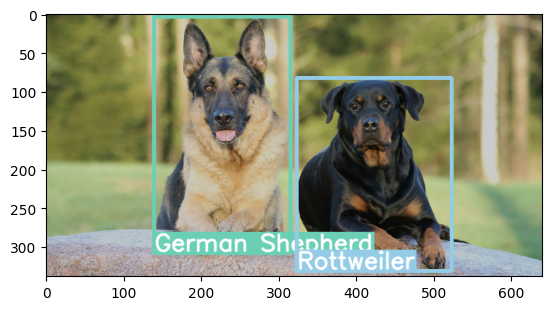

In [41]:
import requests

image_path = "real-life-images/gsd-rottie.jpg"
image = np.array(Image.open(image_path))


result = model.predict(image_path)[0].boxes
rendered_image = render_results(image, result.xywhn.tolist(), result.cls.to(torch.int).tolist())

plt.imshow(rendered_image)

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
100%|██████████| 99.0k/99.0k [00:00<00:00, 1.57MB/s]
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
image 1/1 /Users/vineetmahajan/Code/AI/Projects/Hello/Hello-CNN/Doberman-Pinscher-vs-Rottwelier-900x500.jpg: 384x640 1 Doberman, 1 Rottweiler, 214.7ms
Speed: 2.5ms preprocess, 214.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


['Doberman', 'Rottweiler']

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.


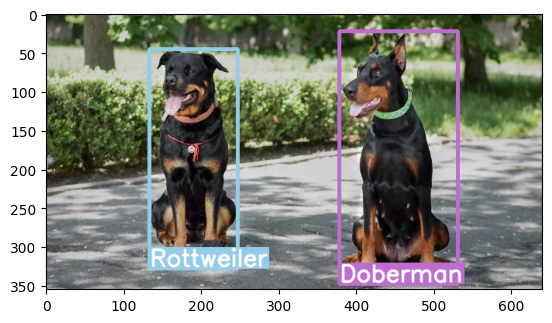

WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camera connection.
WARNING ⚠️ Video stream unresponsive, please check your IP camer

In [54]:
import requests

image_src = "https://c4.wallpaperflare.com/wallpaper/431/601/222/dogs-two-puppy-mom-chow-hd-wallpaper-thumb.jpg"
image = np.array(Image.open(requests.get(image_src, stream=True).raw))
image_src = "https://www.loveyourdog.com/wp-content/uploads/2019/06/Doberman-Pinscher-vs-Rottwelier-900x500.jpg"
image = np.array(Image.open(requests.get(image_src, stream=True).raw))


result = model.predict(image_src)[0].boxes
clsses = result.cls.to(torch.int).tolist()
rendered_image = render_results(image, result.xywhn.tolist(), clsses)

plt.imshow(rendered_image)
[CLASS_NAMES[i] for i in clsses]